In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cPickle as cp
import sys
sys.path.append("../../utils")
from misc_utils import expected_loss
import os
from copy import deepcopy
from plotting_performance_vs_metric import get_closeness, get_log_closeness, get_spectrum
from plotting_performance_vs_metric import get_measurement_metric, get_performance_metric, average_results_array
from plotting_performance_vs_metric import get_nystrom_memory, get_rff_memory
import math

### find the best lambda for exact kernel in real setting

### test cross entropy

In [2]:
l2_reg_list = ["1e-5", "5e-5", "1e-4", "5e-4", "1e-3", "5e-3", "1e-2", "5e-2", "1e-1"]
eval_list = []
lr_list = []
general_folder = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
for l2_reg in l2_reg_list:
    folder_name = general_folder + "/exact_l2_reg_" + l2_reg
    file_name = "eval_metric.txt"
    eval_metric = get_performance_metric(folder_name, file_name)
    eval_list.append(math.sqrt(eval_metric) )
#     lr_list.append(lr)
print eval_list
print "lambda star ", l2_reg_list[np.nanargmin(eval_list)], np.nanmin(eval_list)

[6564.31165090373, 5745.206870065, 5525.99405129353, 5311.761884955423, 5351.492272537793, 5553.823520571003, 5647.835273446682, 5892.5306405146275, 6057.434614975393]
lambda star  5e-4 5311.76188496


### plot spectrum from nystrom and rff

In [3]:
folder_name = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting/census_type_rff_l2_reg_0.0005_n_fp_feat_50000_seed_3"
file_name = "spectrum_train_exact.npy"
exact_spectrum = get_spectrum(folder_name, file_name)
print exact_spectrum

[  1.45065875e+04   3.21118353e+02   2.39649583e+02 ...,   1.57966201e-08
   1.49209259e-08   8.13038312e-18]


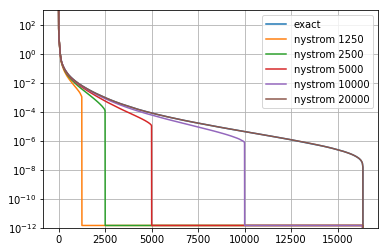

In [4]:
n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
general_folder = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
plt.figure()
plt.semilogy(exact_spectrum, label="exact")
for n_feat in n_nystrom_feat:
    folder_name = general_folder + "/census_type_nystrom_l2_reg_0.0005_n_fp_feat_" + str(n_feat) + "_seed_1"

#     folder_name = general_folder + "/census_type_nystrom_l2_reg_0.0_n_fp_feat_" + str(n_feat) + "_opt_sgd_lr_0.5_seed_1"
    file_name = "spectrum_train.npy"
    spectrum = get_spectrum(folder_name, file_name)
    plt.semilogy(spectrum, label="nystrom " + str(n_feat) )
    
plt.grid()
plt.ylim([1e-12, 1e3] )
plt.legend()
plt.show()

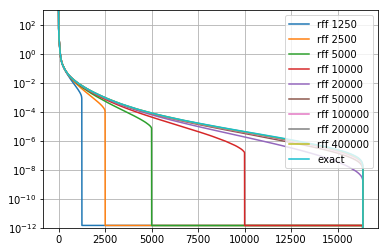

In [5]:
n_rff_feat = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000, 400000]
general_folder = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
plt.figure()
for n_feat in n_rff_feat:
    folder_name = general_folder + "/census_type_rff_l2_reg_0.0005_n_fp_feat_" + str(n_feat) + "_seed_1"
    file_name = "spectrum_train.npy"
    spectrum = get_spectrum(folder_name, file_name)
    plt.semilogy(spectrum, label="rff " + str(n_feat) )
    
plt.semilogy(exact_spectrum, label="exact")

    
plt.grid()
plt.ylim([1e-12, 1e3] )
plt.legend()
plt.show()

### plot performance v.s. approximation error

In [6]:
# # need to customize to deal with python 3 saved files
# def get_spectrum(folder_name, file_name):
#     if os.path.isfile(folder_name + "/" + file_name):
#         with open(folder_name + "/" + file_name, "rb") as f:
#             spectrum = np.load(f)
#         if spectrum[0] < spectrum[-1]:
#             print spectrum[0], spectrum[-1]
#             spectrum = spectrum[::-1]
#     else:
#         print folder_name, file_name, " is not found."
#         spectrum = None
#     return spectrum

# def get_performance_metric(folder_name, file_name, min_best=True):
# #     print folder_name
#     if os.path.isfile(folder_name + "/" + file_name):
#         with open(folder_name + "/" + file_name, "rb") as f:
#             metrics = np.loadtxt(f)
#         if min_best:
#             metric = np.nanmin(metrics)
#         else:
#             metric = np.nanmax(metrics)
#     else:
#         print folder_name, file_name, " is not found."
#         metric = None
#     return metric

def get_measurement_metric(folder_name, file_name, metric_name):
#     print folder_name
    if os.path.isfile(folder_name + "/" + file_name):
        with open(folder_name + "/" + file_name, "r") as f:
            metrics = cp.load(f)
        metric = metrics[metric_name]
    else:
        print folder_name, file_name, " is not found."
        metric = None
    return metric

In [7]:
EPS = 1e-20

In [8]:
def plot_l2_vs_measurement(lamb=0.0, seeds=[1,],
                           rff_mem_func=None, nystrom_mem_func=None):
    n_rff_feat = [1250, 2500, 5000, 10000, 20000, 50000, 100000, 200000]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/delta/regression_real_setting"
    # plt.figure()
    f_norm_list_rff = []
    spectral_norm_list_rff = []
    closeness_list_rff = []
    log_closeness_list_rff = []
    test_loss_list_rff = []
    l2_loss_list_rff = []
    delta_list_rff = []
    
    for seed in seeds:
        f_norm_list = []
        spectral_norm_list = []
        closeness_list = []
        log_closeness_list = []
        l2_loss_list = []
        delta_list = []
        for n_feat in n_rff_feat:
            folder_name = general_folder_measurement + "/census_type_rff_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "spectrum_eval.npy"
            spectrum = get_spectrum(folder_name, file_name)

            file_name = "spectrum_eval_exact.npy"
            exact_spectrum = get_spectrum(folder_name, file_name)
            
            file_name = "metric_sample_eval_py2.txt"
            metric_name = "F_norm_error"
            f_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            f_norm_list.append(f_norm_error)

            metric_name = "spectral_norm_error"
            spectral_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            spectral_norm_list.append(spectral_norm_error)

            closeness = get_closeness(spectrum, exact_spectrum, lamb=float(lamb) + EPS)
            closeness_list.append(closeness)

            log_closeness = get_log_closeness(spectrum, exact_spectrum, lamb=float(lamb) + EPS)
            log_closeness_list.append(log_closeness)   

            folder_name = general_folder_performance + "/census_type_rff_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "eval_metric.txt"
            l2_loss = get_performance_metric(folder_name, file_name, min_best=True)
            l2_loss_list.append(l2_loss)
            
            folder_name = general_folder_delta + "/census_type_rff_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "metric_sample_eval.txt"
            metric_name = "Delta"
            delta = get_measurement_metric(folder_name, file_name, metric_name)
            delta_list.append(delta)
#             print "ckpt", log_closeness_list
        
        f_norm_list_rff.append(np.array(deepcopy(f_norm_list) ) )
        spectral_norm_list_rff.append(np.array(deepcopy(spectral_norm_list) ) )
        closeness_list_rff.append(np.array(deepcopy(closeness_list) ) )
        log_closeness_list_rff.append(np.array(deepcopy(log_closeness_list) ) )
        l2_loss_list_rff.append(np.array(deepcopy(l2_loss_list) ) )
        delta_list_rff.append(np.array(deepcopy(delta_list) ) )
        
    f_norm_list_rff = average_results_array(f_norm_list_rff)
    spectral_norm_list_rff = average_results_array(spectral_norm_list_rff)
    closeness_list_rff = average_results_array(closeness_list_rff)
    log_closeness_list_rff = average_results_array(log_closeness_list_rff)
    l2_loss_list_rff = average_results_array(l2_loss_list_rff)
    delta_list_rff = average_results_array(delta_list_rff)
    memory_list_rff = np.array( [rff_mem_func(n_feat) for n_feat in n_rff_feat] )


    # get info for nystrom method
    n_nystrom_feat = [1250, 2500, 5000, 10000, 20000]
    general_folder_measurement = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
    general_folder_performance = "/dfs/scratch0/zjian/lp_kernel/closeness/regression_real_setting"
    general_folder_delta = "/dfs/scratch0/zjian/lp_kernel/delta/regression_real_setting"
    # plt.figure()
    f_norm_list_nystrom = []
    spectral_norm_list_nystrom = []
    closeness_list_nystrom = []
    log_closeness_list_nystrom = []
    l2_loss_list_nystrom = []
    delta_list_nystrom = []
    
    for seed in seeds:
        f_norm_list = []
        spectral_norm_list = []
        closeness_list = []
        log_closeness_list = []
        l2_loss_list = []
        delta_list = []
        for n_feat in n_nystrom_feat:
            folder_name = general_folder_measurement + "/census_type_nystrom_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "spectrum_eval.npy"
            spectrum = get_spectrum(folder_name, file_name)
            
            file_name = "spectrum_eval_exact.npy"
            exact_spectrum = get_spectrum(folder_name, file_name)

            file_name = "metric_sample_eval_py2.txt"
            metric_name = "F_norm_error"
            f_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            f_norm_list.append(f_norm_error)

            metric_name = "spectral_norm_error"
            spectral_norm_error = get_measurement_metric(folder_name, file_name, metric_name)
            spectral_norm_list.append(spectral_norm_error)

            closeness = get_closeness(spectrum, exact_spectrum, lamb=float(lamb) + EPS)
            closeness_list.append(closeness)

            log_closeness = get_log_closeness(spectrum, exact_spectrum, lamb=float(lamb) + EPS)
            log_closeness_list.append(log_closeness)    

            folder_name = general_folder_performance + "/census_type_nystrom_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "eval_metric.txt"
            l2_loss = get_performance_metric(folder_name, file_name, min_best=True)
            l2_loss_list.append(l2_loss)
            
            folder_name = general_folder_delta + "/census_type_nystrom_l2_reg_" + str(lamb) + "_n_fp_feat_" + str(n_feat) + "_seed_" + str(seed)
            file_name = "metric_sample_eval.txt"
            metric_name = "Delta"
            delta = get_measurement_metric(folder_name, file_name, metric_name)
            delta_list.append(delta)

        f_norm_list_nystrom.append(np.array(deepcopy(f_norm_list) ) )
        spectral_norm_list_nystrom.append(np.array(deepcopy(spectral_norm_list) ) )
        closeness_list_nystrom.append(np.array(deepcopy(closeness_list) ) )
        log_closeness_list_nystrom.append(np.array(deepcopy(log_closeness_list) ) )
        l2_loss_list_nystrom.append(np.array(deepcopy(l2_loss_list) ) )
        delta_list_nystrom.append(np.array(deepcopy(delta_list) ) )

        
    f_norm_list_nystrom = average_results_array(f_norm_list_nystrom)
    spectral_norm_list_nystrom = average_results_array(spectral_norm_list_nystrom)
    closeness_list_nystrom = average_results_array(closeness_list_nystrom)
    log_closeness_list_nystrom = average_results_array(log_closeness_list_nystrom)
    l2_loss_list_nystrom = average_results_array(l2_loss_list_nystrom)
    delta_list_nystrom = average_results_array(delta_list_nystrom)
    memory_list_nystrom = np.array( [nystrom_mem_func(n_feat) for n_feat in n_nystrom_feat] )

    plt.figure()
    plt.plot(f_norm_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(f_norm_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs f norm")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(spectral_norm_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(spectral_norm_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs spectral norm")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()
    
    plt.figure()
    plt.plot(delta_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(delta_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs Delta")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()
    
    plt.figure()
    plt.plot(memory_list_rff, delta_list_rff, "-o", label="rff")
    plt.plot(memory_list_nystrom, delta_list_nystrom, "-o", label="nystrom")
    plt.title("Delta vs memory")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()
    
    plt.figure()
    plt.plot(memory_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(memory_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs memory")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()
    

    plt.figure()
    plt.plot(closeness_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(closeness_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs closeness")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()
#     print "final ", log_closeness_list_rff, log_closeness_list_nystrom
    
    plt.figure()
    plt.plot(log_closeness_list_rff, np.sqrt(np.array(l2_loss_list_rff).astype(np.float64) ), "-o", label="rff")
    plt.plot(log_closeness_list_nystrom, np.sqrt(np.array(l2_loss_list_nystrom).astype(np.float64) ), "-o", label="nystrom")
    plt.title("l2 vs log closeness")
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
#     plt.xlim([1e-3, 1e4])
    plt.grid()
    plt.show()

In [9]:
# label noise sigma     lambda
# 1e3                   1.76055378e-06
# 1e4                   0.00431012
# 1e2                   0.0
# 1e5                   1.04123522

In [10]:
m = 250
r = 119
rff_mem_func = lambda n : get_rff_memory(n, m, r)
nystrom_mem_func = lambda n : get_nystrom_memory(n, m, r)

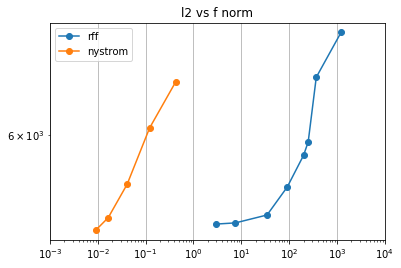

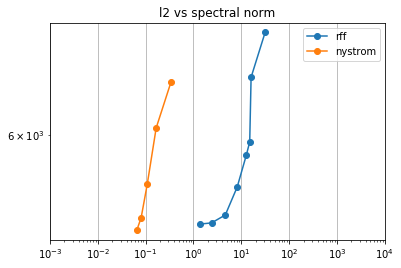

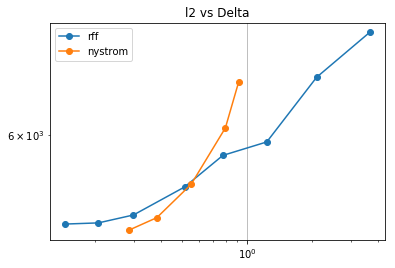

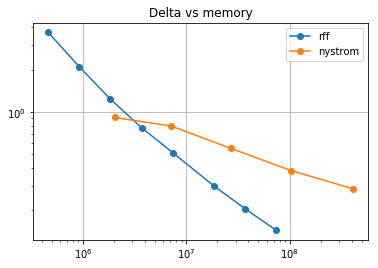

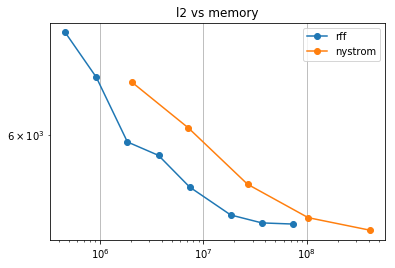

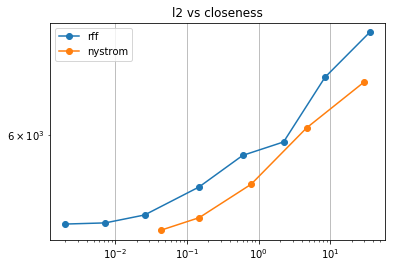

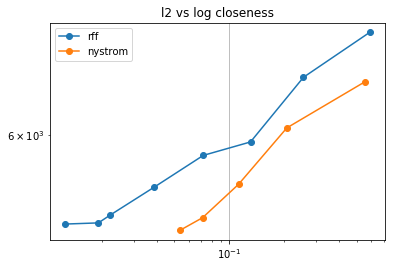

In [11]:
plot_l2_vs_measurement(lamb="0.0005", seeds=[1,2,3,],
                      rff_mem_func=rff_mem_func,
                      nystrom_mem_func=nystrom_mem_func)